In [17]:
import pandas
import numpy
import matplotlib.pyplot as plt
import matplotlib
from sompy.sompy import SOMFactory
%matplotlib inline

In [4]:
w = numpy.load('data/wavelength_grid_red.npy')
X = numpy.load('data/spectra_red.npy')
SpecObjIDS = numpy.load('data/specobjids_red.npy').astype(int)
nof_objects = X.shape[0]
nof_features = X.shape[1]
print('Number of galaxies: {}\nNumber of flux values: {}'.format(nof_objects, nof_features))

Number of galaxies: 50000
Number of flux values: 2676


# Creating the SOM
* Using the SOMPY package --- https://github.com/sevamoo/SOMPY
* Additional usage examples are available at: https://github.com/sevamoo/SOMPY/tree/master/sompy/examples

In [5]:
%%time
n_rows = 20
n_cols = 20
sm = SOMFactory().build(X, mapsize=[n_rows,n_cols],normalization = None, initialization='pca')
sm.train(n_job=4, verbose=False, train_rough_len=30, train_finetune_len=100)

/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: RuntimeWarning: overflow encountered in multiply
  return getattr(obj, method)(*args, **kwds)
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/SOMPY-1.0-py3.6.egg/sompy/sompy.py:709: RuntimeWarning: invalid value encountered in add
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/SOMPY-1.0-py3.6.egg/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/SOMPY-1.0-py3.6.egg/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt


CPU times: user 28min 34s, sys: 2min 9s, total: 30min 43s
Wall time: 12min 16s


# Plotting the SOM
* Note the the SOMPY packge includes various visualizations of the results, see https://github.com/sevamoo/SOMPY/tree/master/sompy/examples
* Here we plot the representative spectra of each cell in the SOM

In [6]:
# The following matrix contains the prototype spectra for each cell in the SOM
#som_matrix = numpy.load('som_results/som_matrix.npy') # a file with saved results, in case the SOM run failed
som_matrix = sm.codebook.matrix.copy()
som_matrix.shape

(400, 2676)

In [20]:
matplotlib.use('agg')

cmap = matplotlib.cm.get_cmap('Spectral_r')
wave_index = numpy.linspace(0,0.9,X.shape[1])
spec_arr = numpy.empty([n_cols,n_rows], dtype=numpy.ndarray)
scolor = numpy.zeros(spec_arr.shape)

for r in range(n_rows):
    for c in range(n_cols):
        idx = c + r*n_cols
        avg_spec = som_matrix[idx].copy()
        spec_arr[c,r] = avg_spec/(numpy.max(avg_spec) - numpy.min(avg_spec))
        scolor[c,r] = numpy.sum(spec_arr[c,r]*w)
scolor = (scolor-numpy.min(scolor))/numpy.max(scolor)

fig = plt.figure(  figsize = (100,100))
x_offset = 1 # tune these
y_offset = 1.2 # tune these

for r in range(n_rows):
    for c in range(n_cols):
        
        #if ws_arr[k,l] > 0:
            #color = cmap(ws_arr[k,l]/ws_max)
        idx = c + r*n_cols
        plt.text(x=r*x_offset,y=c*y_offset,s=str(idx))
        #ax.plot(wave_index + r*x_offset,spec_arr[c,r] + c*y_offset, c=cmap( (counts[idx] - numpy.min(counts))/ numpy.max(counts)) )
        plt.plot(wave_index + r*x_offset,spec_arr[c,r] + c*y_offset, c=cmap(scolor[c,r]) )
plt.tight_layout()
plt.axis('off')
file_name = 'som_results/SOM_galaxies.eps'
fig.savefig(file_name, format='eps')
plt.close(fig)    
print('The SOM was saved to', file_name)

/Users/itamar/anaconda2/envs/ciwsa_/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  """Entry point for launching an IPython kernel.


* In the saved figure there is an index next to each spectra. We can use the index to retrieve all the galaxies associated with the cell.

In [21]:
import matplotlib.image as mpimg
def print_sdss_link(SpecObjID):
    SpecObjID = str(int(SpecObjID))
    print('http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?sid=' + str(SpecObjID) + '&apid=')
    return
def show_sdss_spectra(specobjid):
    print_sdss_link(specobjid)
    plt.figure(figsize = (10,7))
    plt.imshow(mpimg.imread('http://skyserver.sdss.org/dr14/en/get/SpecById.ashx?id=' + dr14_specobjid))
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [75]:
#cells = numpy.load('som_results/cells.npy') # saved results in case the SOM run failed
cells = sm._bmu[0].astype(int) # this array containes the index of the cell each galaxy is associated with
cell = 180
sub_sample = numpy.where(cells == cell)[0] # example: get all galaxies from the 388th cell (see SOM figure)

* comparing a galaxy spectra to the prototype spectra of its cell:

<IPython.core.display.Javascript object>


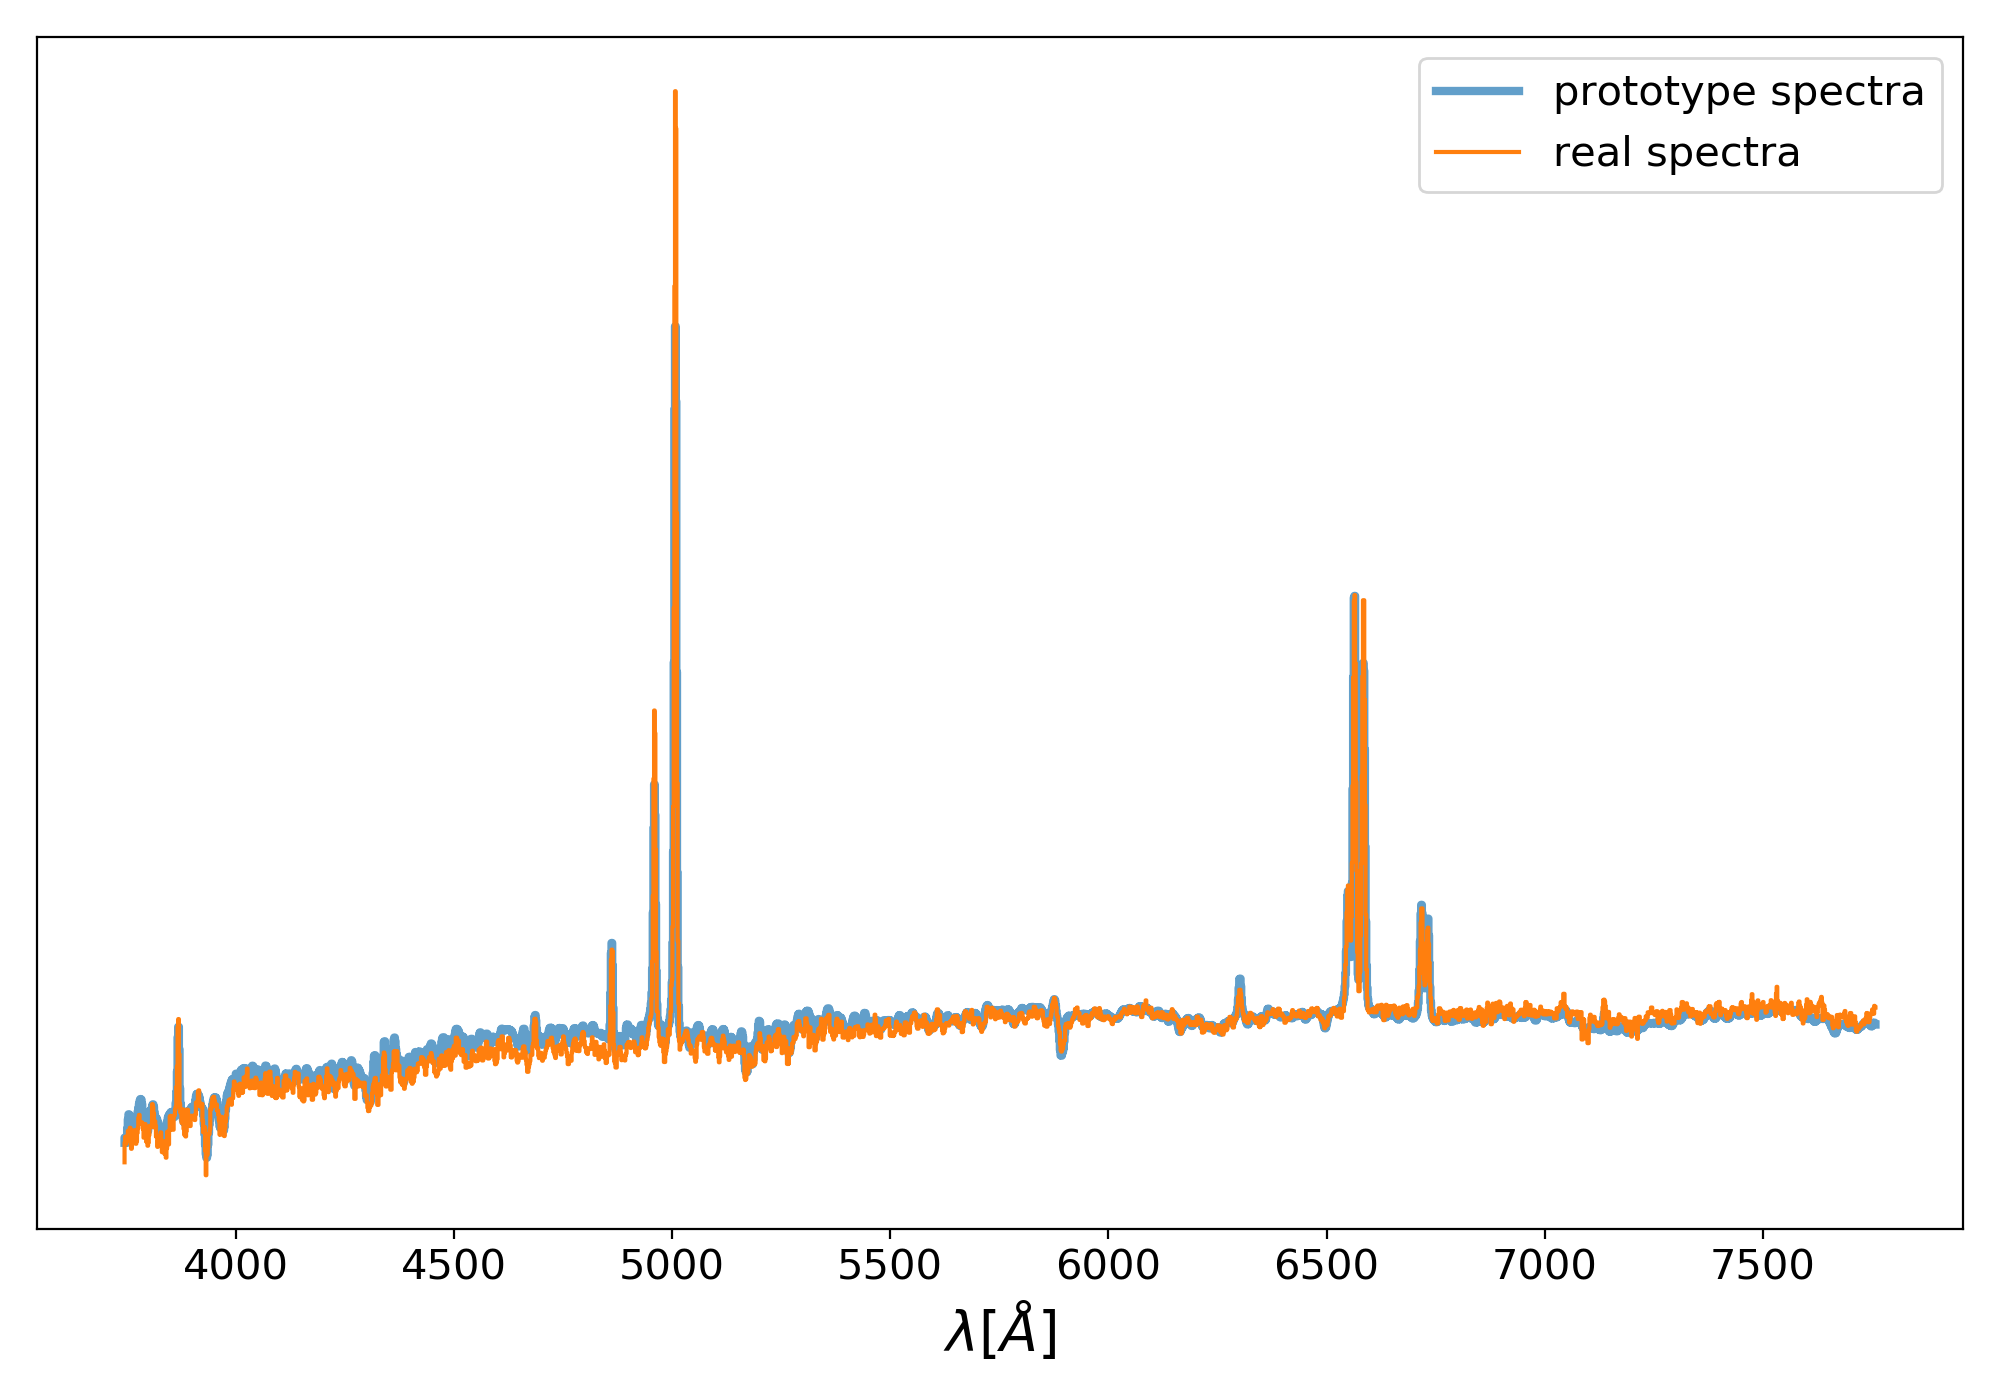

In [58]:
%matplotlib notebook
plt.figure(figsize = (10,7))
plt.step(w, som_matrix[cell], alpha = 0.7, lw = 3, label = 'prototype spectra')
plt.step(w, X[numpy.random.choice(sub_sample)], alpha = 1, label = 'real spectra') 
plt.legend(fontsize = 15)
plt.yticks([])
plt.xticks(fontsize = 15)
plt.xlabel(r'$\lambda [\AA]$', fontsize = 20)
plt.tight_layout()
plt.show()

# Outliers 1
* galaxies with spectra that does not match their cell prototype

In [96]:
X_som = som_matrix[cells]
error = numpy.mean(numpy.abs(X_som - X), axis = 1)
outliers = numpy.argsort(error)[::-1][:100]

<IPython.core.display.Javascript object>


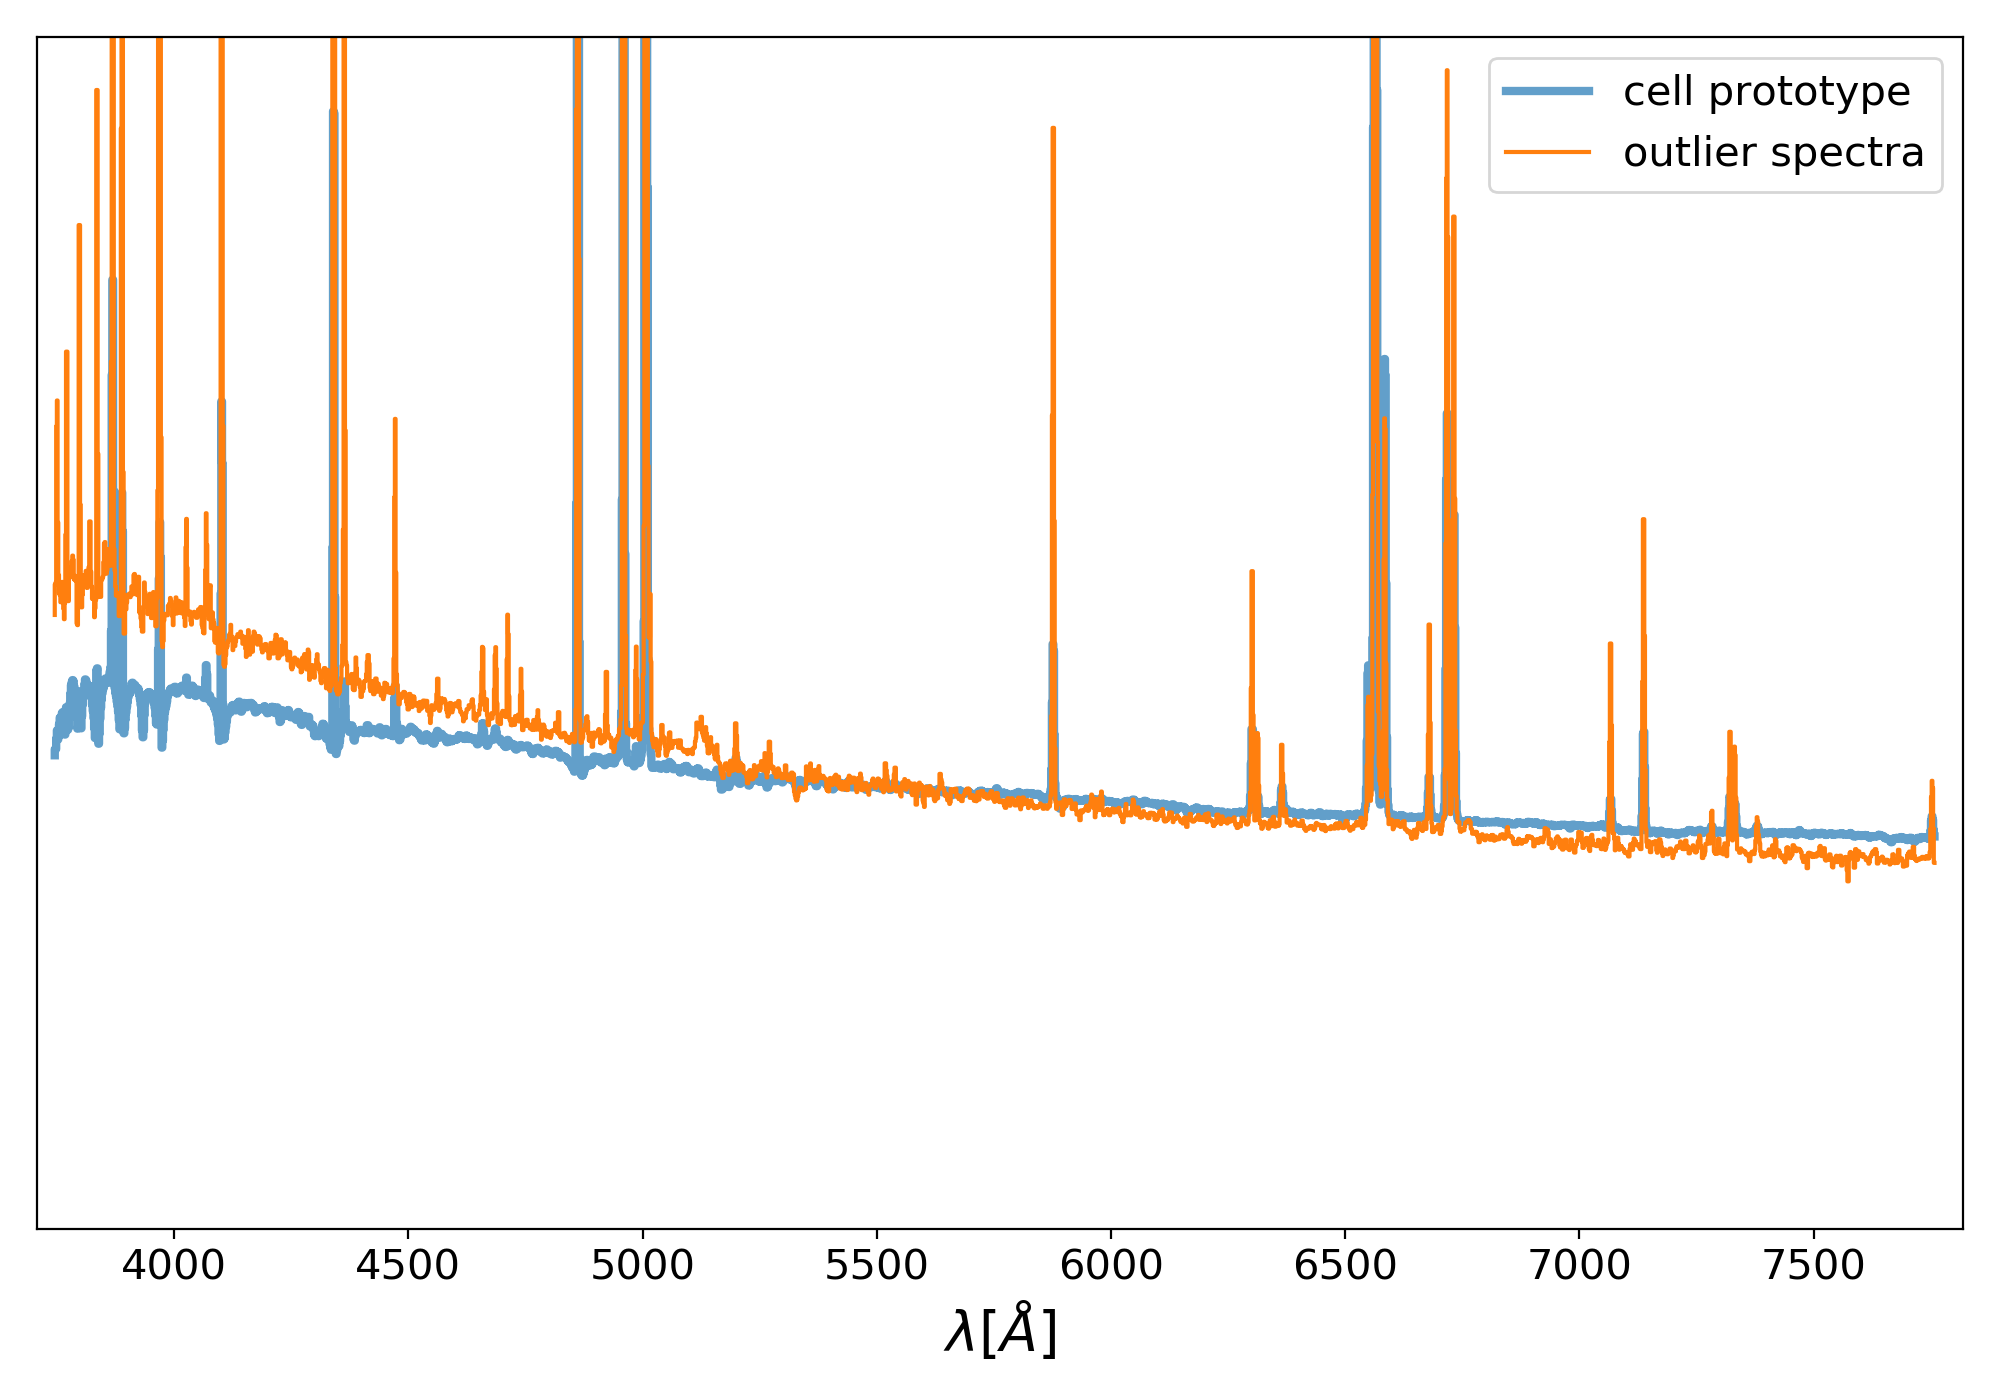

In [97]:
%matplotlib notebook
i = 0
idx = outliers[i]
plt.figure(figsize = (10,7))
plt.step(w, som_matrix[cells[idx]], alpha = 0.7, lw = 3, label = 'cell prototype')
plt.step(w, X[idx], alpha = 1, label = 'outlier spectra') 
plt.legend(fontsize = 15)
plt.yticks([])
plt.xticks(fontsize = 15)
plt.xlabel(r'$\lambda [\AA]$', fontsize = 20)
plt.tight_layout()
plt.show()

http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?sid=6036086389992300544&apid=


<IPython.core.display.Javascript object>


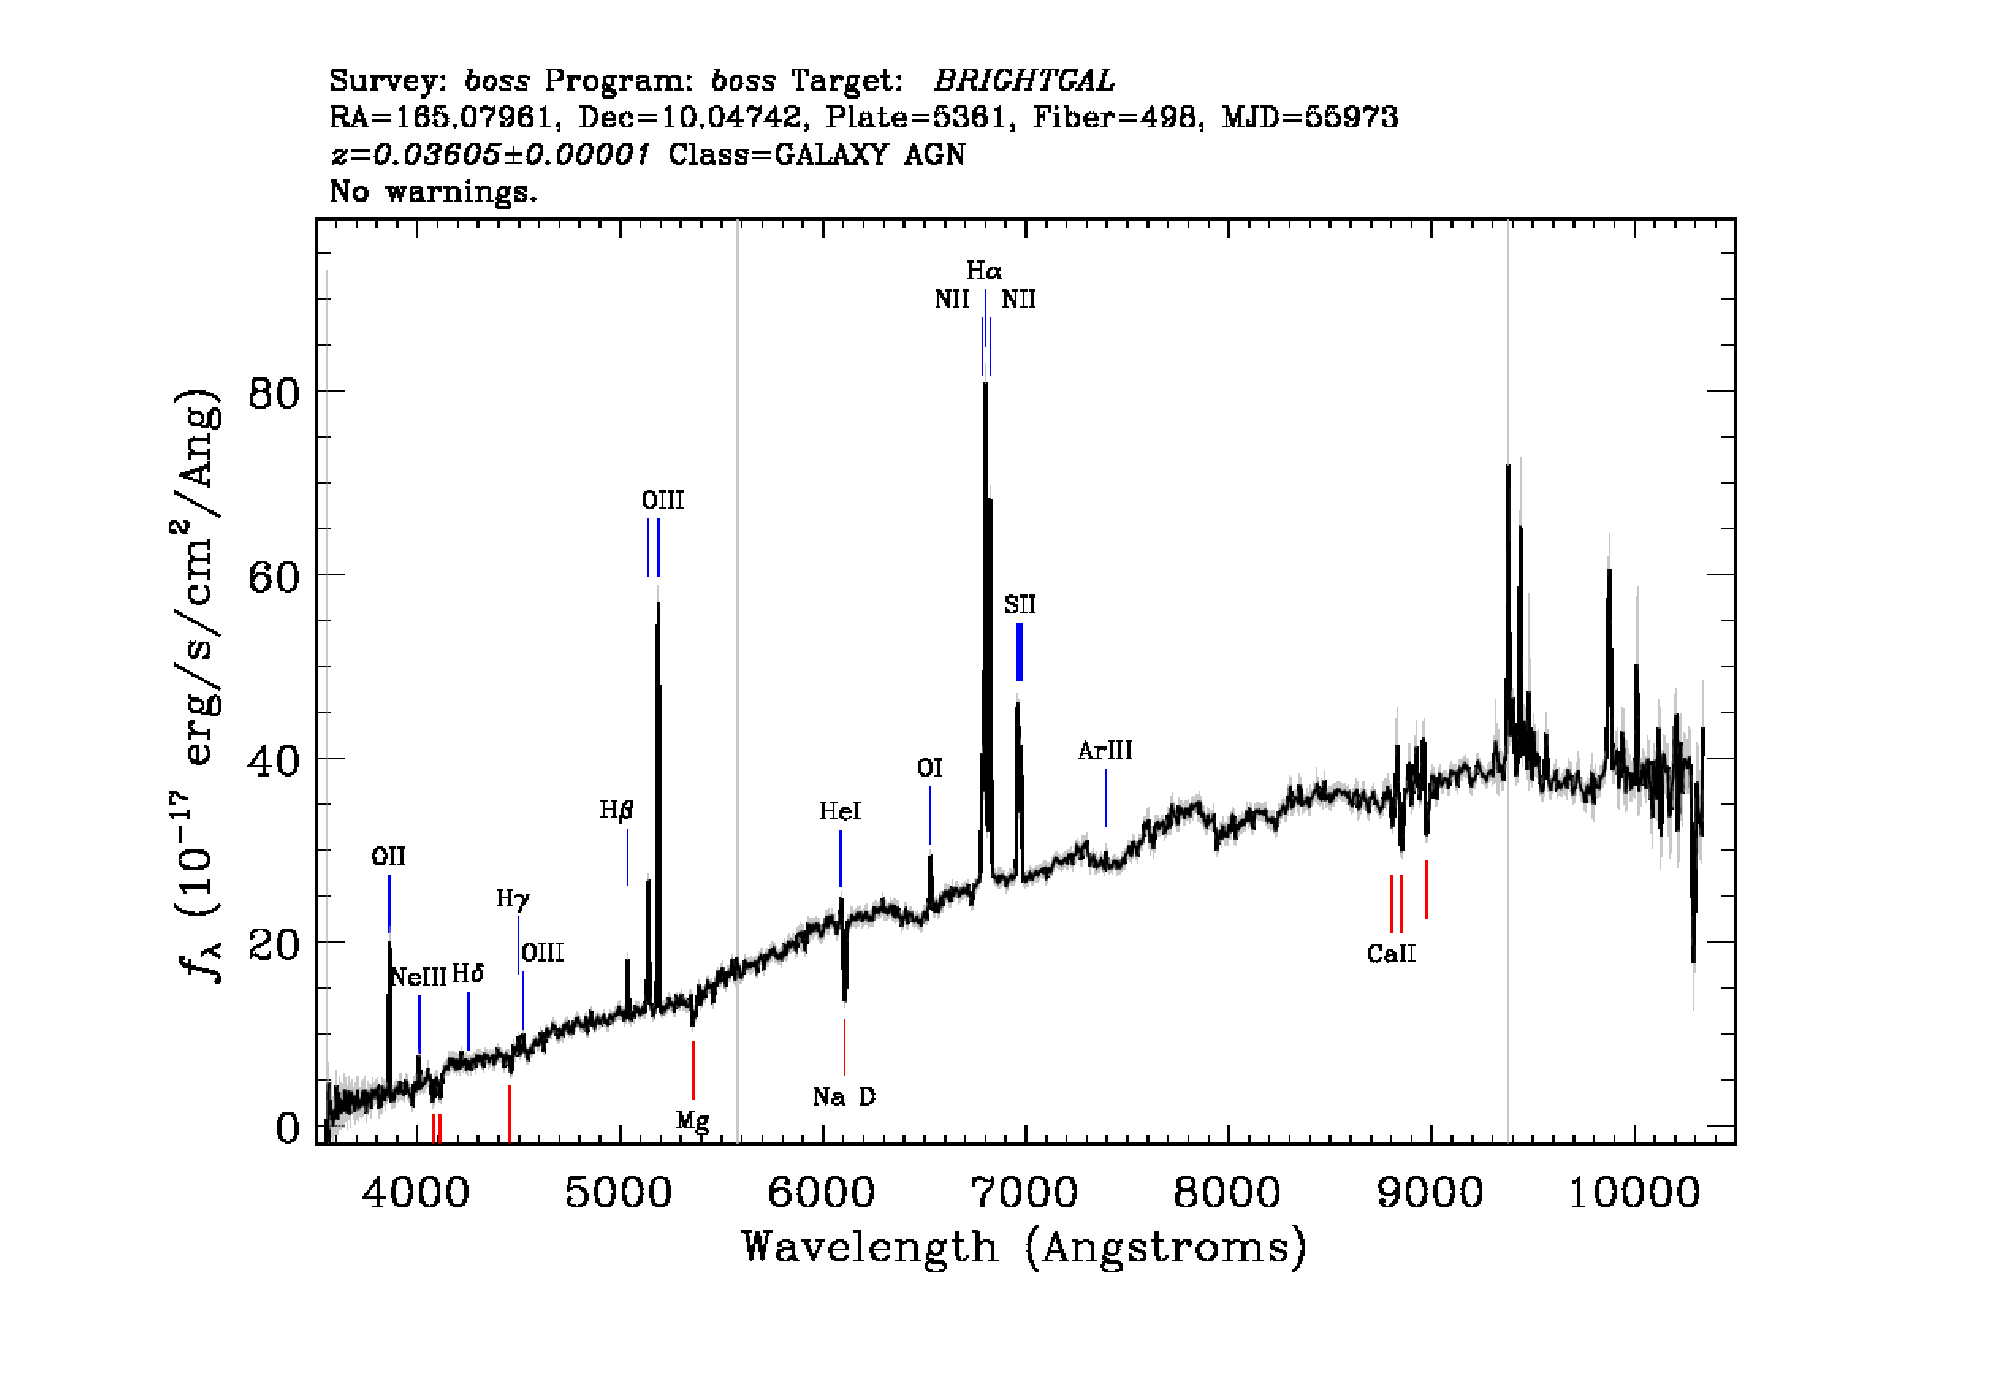

In [77]:
dr14_specobjid = str(SpecObjIDS[idx])
show_sdss_spectra(dr14_specobjid)

# Outliers 2
* objects that reside in low density cells

In [ ]:
from collections import Counter
counts = Counter(sm._bmu[0])
counts = [counts.get(x, 0) for x in range(n_rows * n_cols)]

<IPython.core.display.Javascript object>


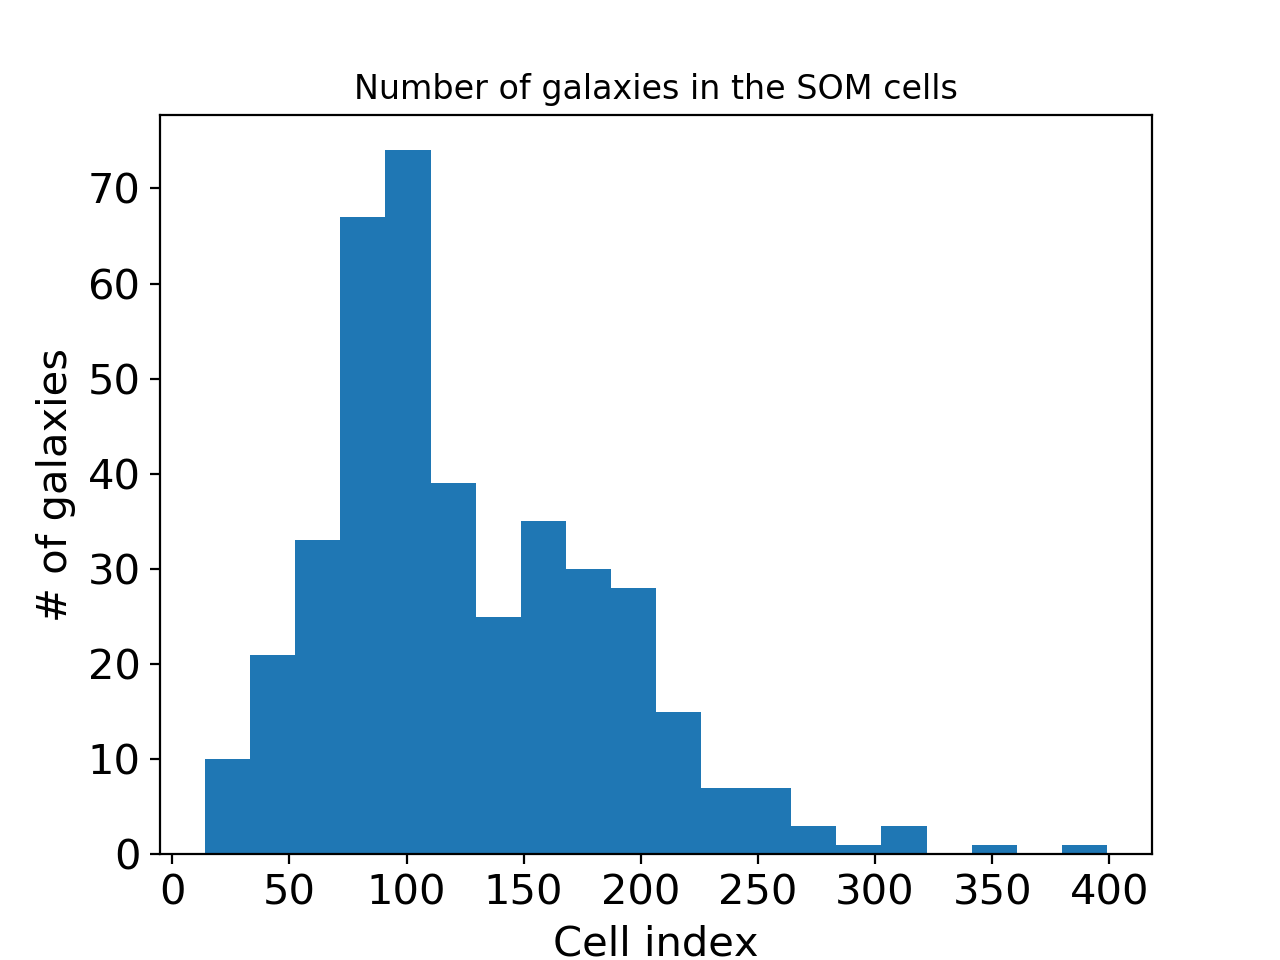

In [101]:
plt.figure()
plt.title('Number of galaxies in the SOM cells')
plt.hist(counts, bins = 20)
plt.xlabel('Cell index', fontsize = 15)
plt.ylabel('# of galaxies', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [116]:
outliers_cells = numpy.argsort(counts)[:5]
cell = outliers_cells[3]
outliers = numpy.where(cells == cell)[0] # objects from the cell with the lowest number of objects
outliers

array([  391,   898,  1265,  2916,  3001,  4692,  7969, 13860, 14923,
       19205, 19754, 20018, 20111, 22383, 23247, 27698, 27767, 28761,
       29147, 30478, 38199, 38818, 39011, 40071, 40267, 49128])

<IPython.core.display.Javascript object>


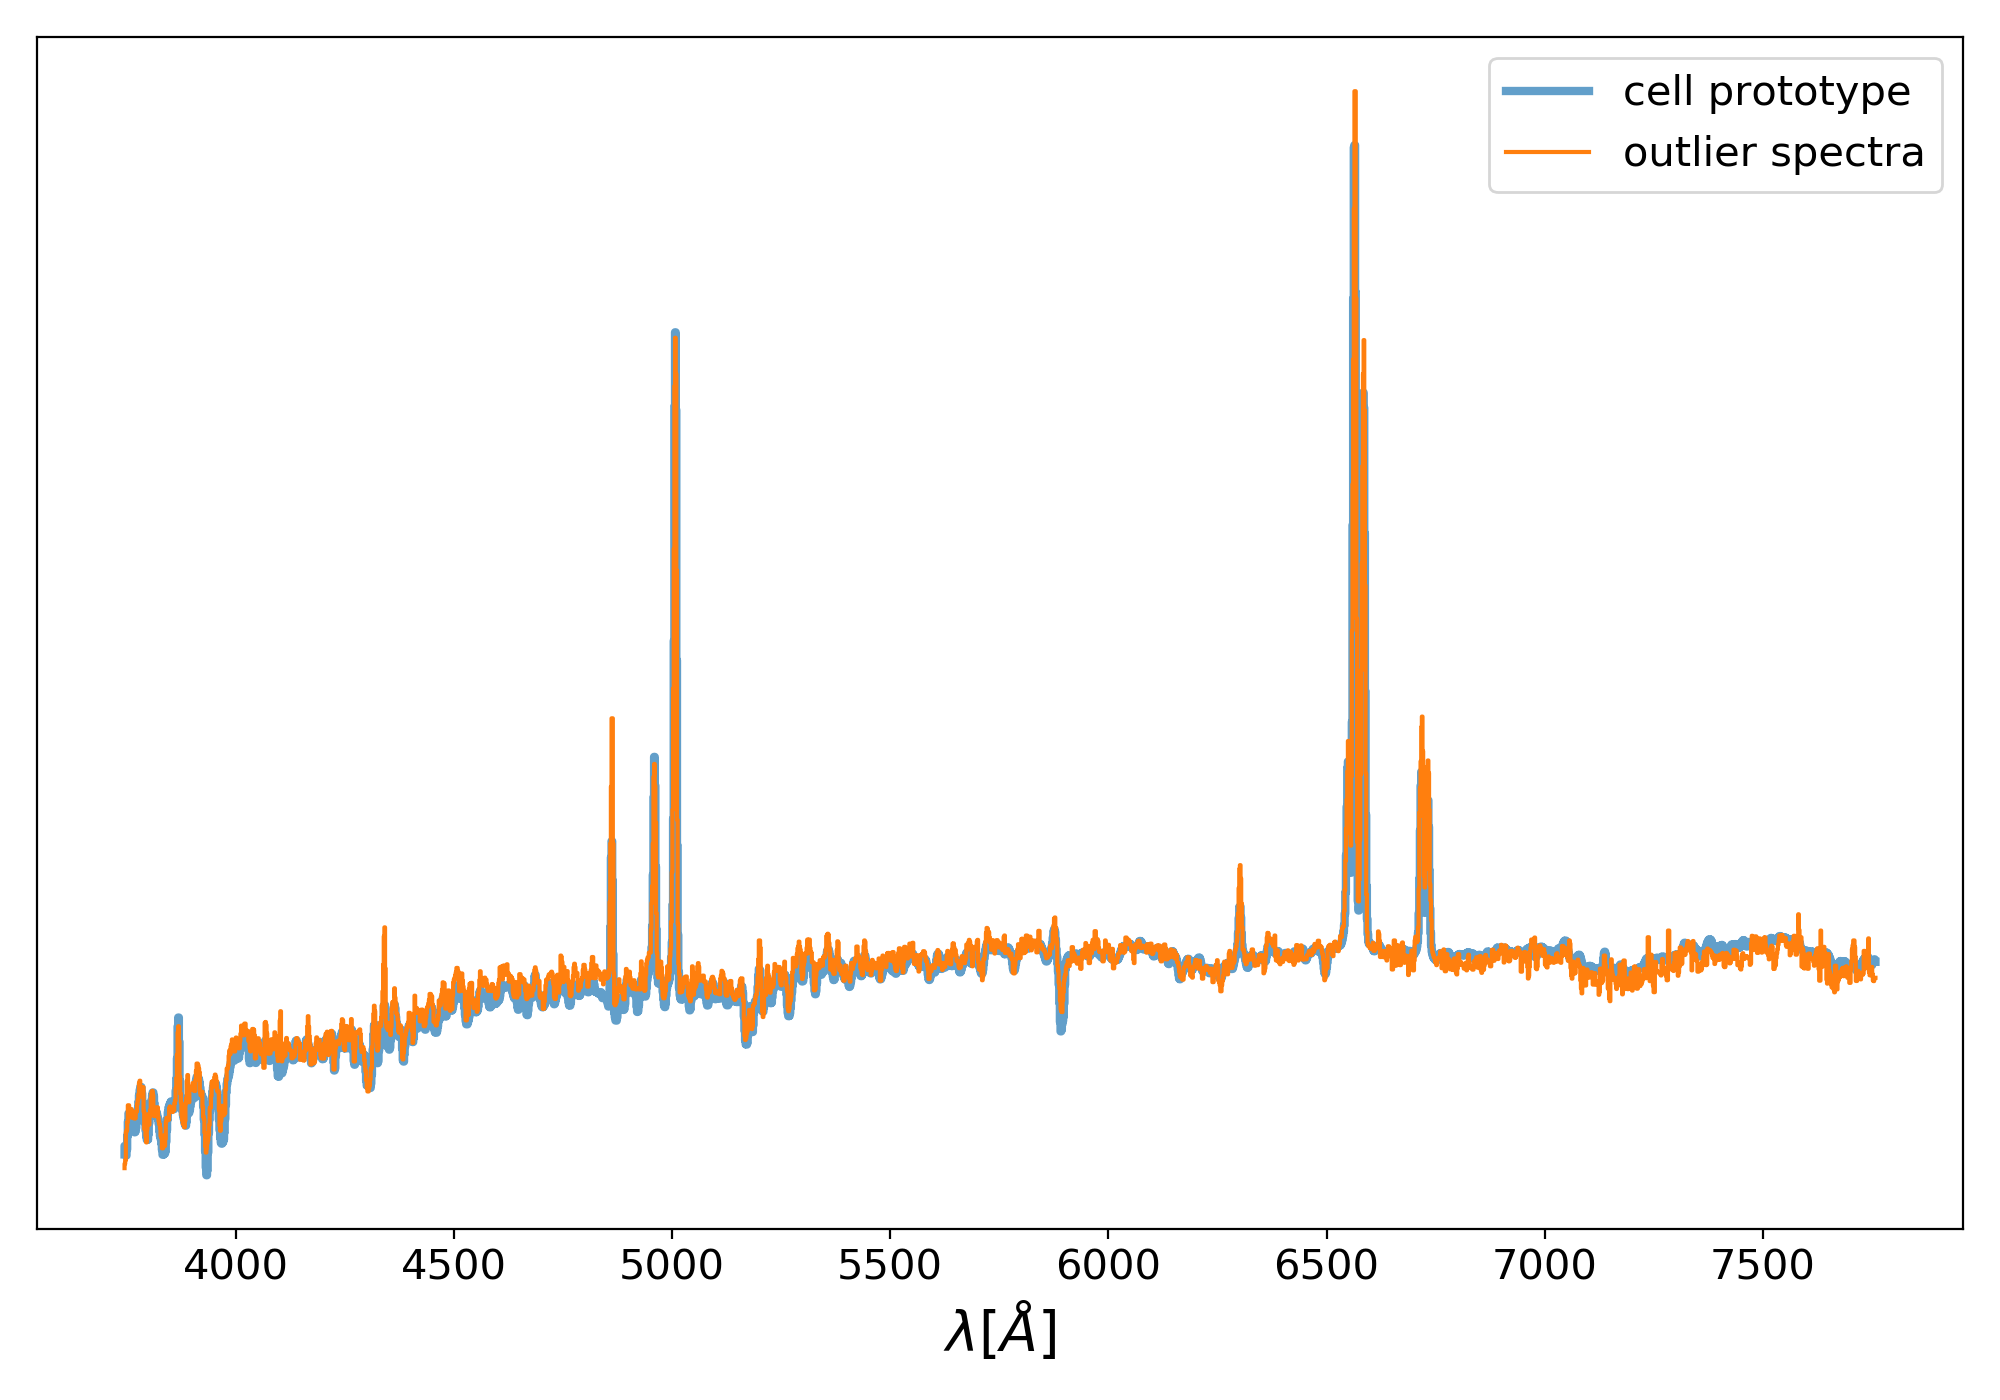

In [117]:
%matplotlib notebook
i = 0
idx = outliers[i]
plt.figure(figsize = (10,7))
plt.step(w, som_matrix[cell], alpha = 0.7, lw = 3, label = 'cell prototype')
plt.step(w, X[idx], alpha = 1, label = 'outlier spectra') 
plt.legend(fontsize = 15)
plt.yticks([])
plt.xticks(fontsize = 15)
plt.xlabel(r'$\lambda [\AA]$', fontsize = 20)
plt.tight_layout()
plt.show()

http://skyserver.sdss.org/dr14/en/tools/explore/summary.aspx?sid=462770456781416448&apid=


<IPython.core.display.Javascript object>


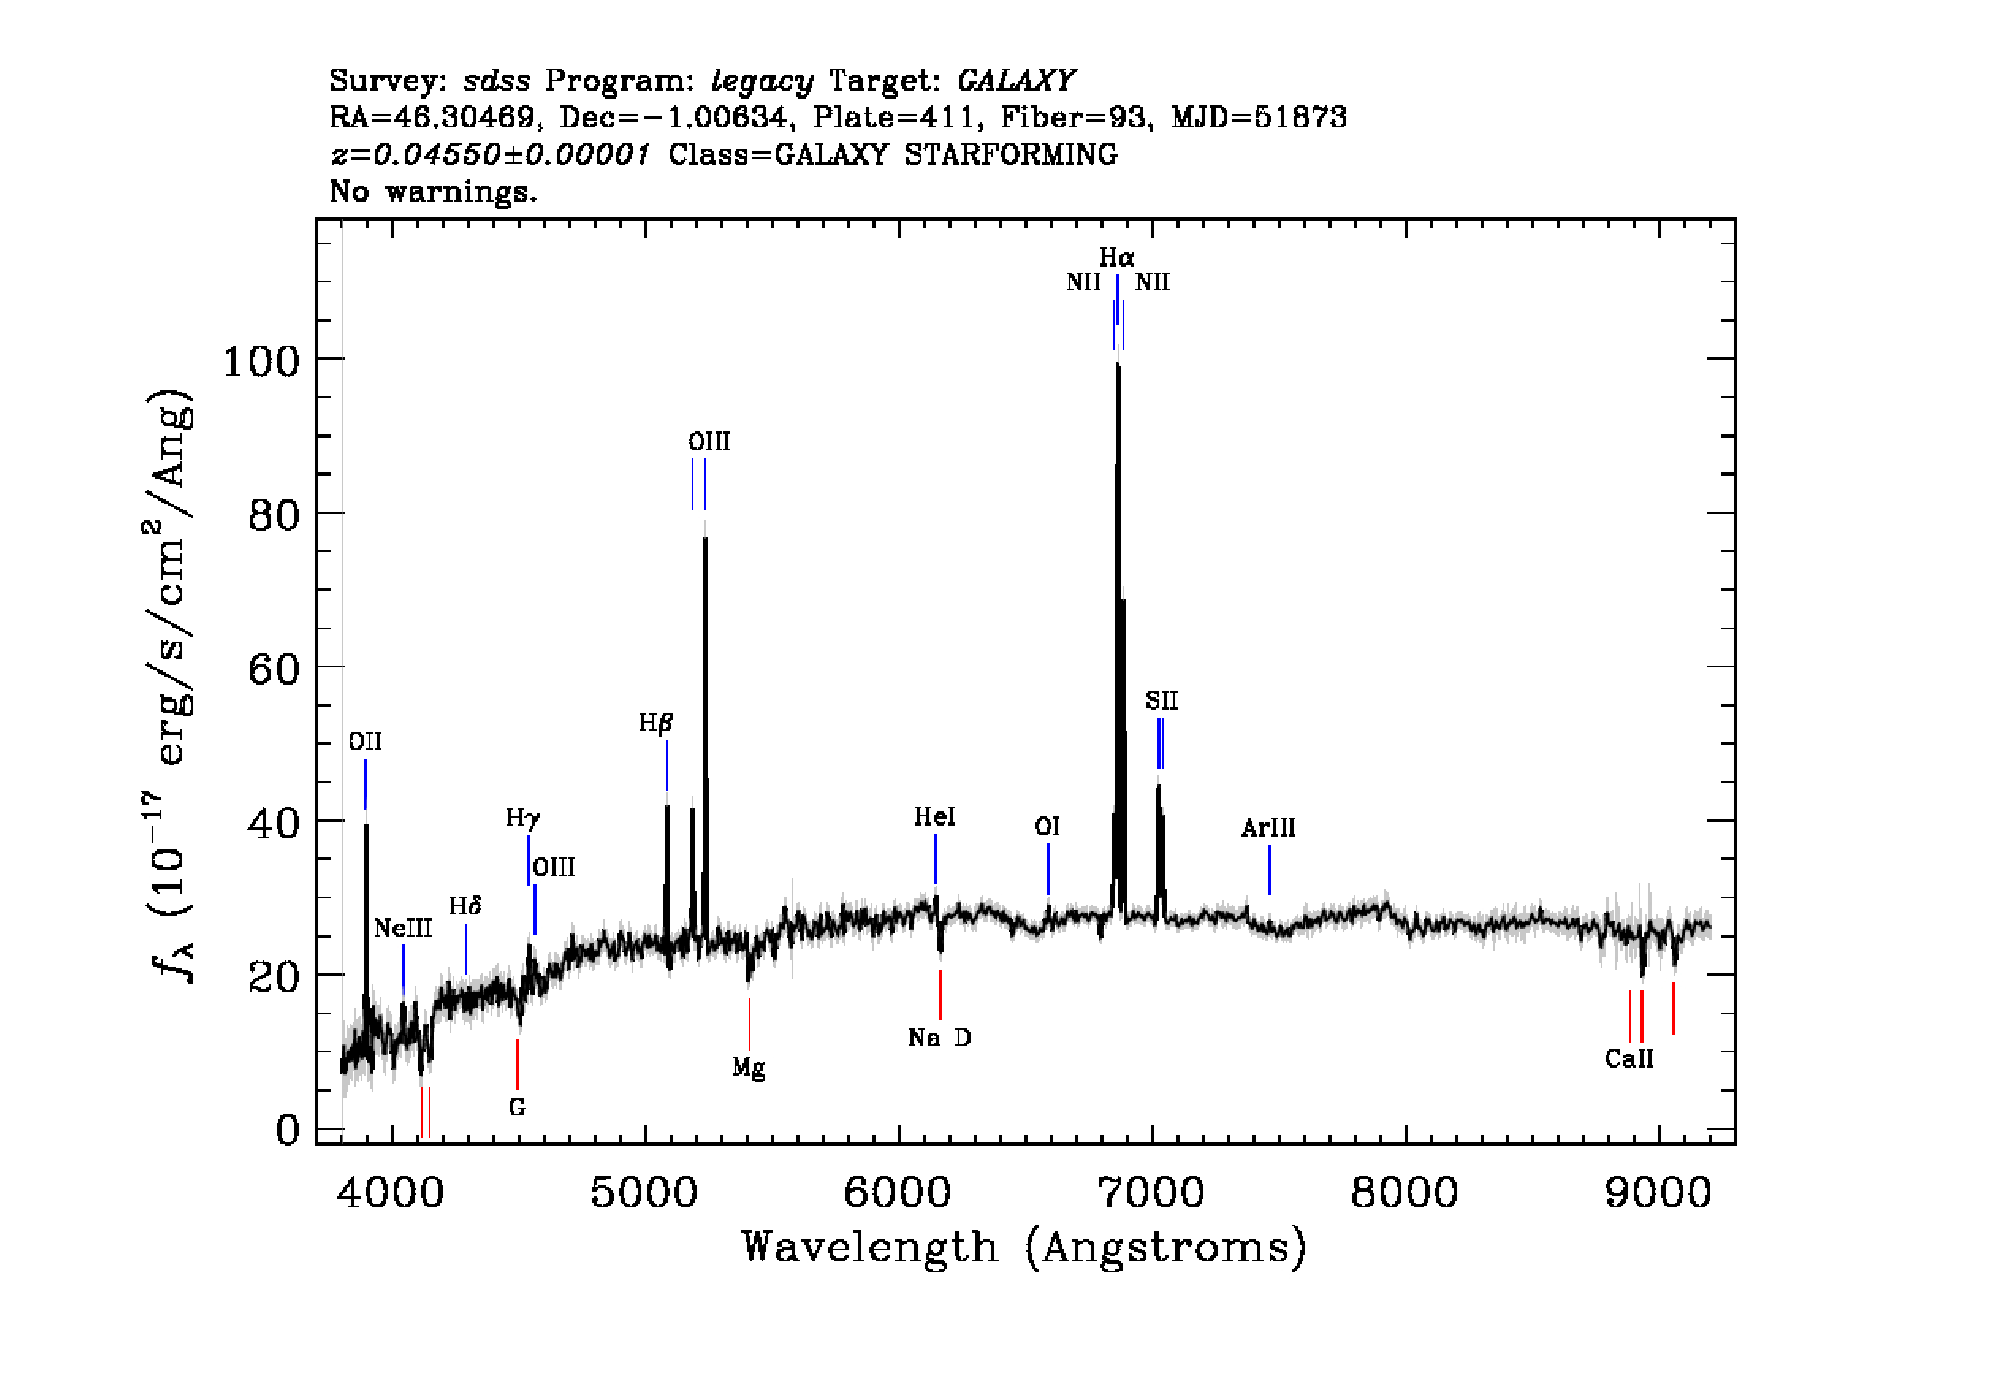

In [118]:
dr14_specobjid = str(SpecObjIDS[outliers[4]])
show_sdss_spectra(dr14_specobjid)